# Lesson 14 - what does our data look like?

In lesson 13 you printed out a percentage for how well the NHS is prescribing 5 days of 500 mg Amoxicillin. However, this only gave you an average over all of the data available. The results from lesson 13 did not `show` you how things were improving, worsening or even static over time. For this, you need to plot out the data over time. Let's do just that.

First let's import some components you have seen before and create a Path object to the "data" folder

P.S. If you click on the `Run` menu at the top of JupyterLabs and then on `Run All Cells`, then all of the code below will be run and you will hopefully get a nice plot. Check it out. Afterwards, come back up to the top here and we can walk through the code together.

In [9]:
from pathlib import Path
from ebmdatalab import bq

DATA_FOLDER = Path("data")

In [10]:
denominator_sql = """
    SELECT month, SUM(items) AS denominator_items
    FROM `ebmdatalab.hscic.raw_prescribing_normalised`
    WHERE bnf_code LIKE '0501013B0%AB'
    GROUP BY month
    ORDER BY month
"""

denominator = bq.cached_read(denominator_sql, DATA_FOLDER / "amoxicillin_denominator_by_month.csv", use_cache=True)

In [11]:
numerator_sql = """
    SELECT month, SUM(items) AS numerator_items
    FROM `ebmdatalab.hscic.raw_prescribing_normalised`
    WHERE bnf_code LIKE '0501013B0%AB' AND quantity_per_item = 15
    GROUP BY month
    ORDER BY month
"""

numerator = bq.cached_read(numerator_sql, DATA_FOLDER / "amoxicillin_numerator_by_month.csv", use_cache=True)

In [12]:
import pandas as pd

# --- 3) Tidy types: ensure month is datetime; columns are numeric ---
for df in (denominator, numerator):
    # ebmdatalab returns month as YYYY-MM-01 string; parse to datetime
    df["month"] = pd.to_datetime(df["month"])
    # make sure sums are numeric
    for col in df.columns:
        if col.endswith("_items"):
            df[col] = pd.to_numeric(df[col], errors="coerce")

In [13]:
# --- 4) Merge and compute fraction/percentage ---
# Outer join preserves months that appear in one side only; fill missing with 0
df = pd.merge(denominator, numerator, on="month", how="outer").sort_values("month")
df[["denominator_items", "numerator_items"]] = df[["denominator_items", "numerator_items"]].fillna(0)

In [14]:
# Avoid divide-by-zero
df["fraction"] = df.apply(
    lambda r: (r["numerator_items"] / r["denominator_items"]) if r["denominator_items"] else 0,
    axis=1,
)

df["percentage"] = df["fraction"] * 100

In [15]:
# (Optional) save the combined dataset for inspection/reuse
out_path = DATA_FOLDER / "amoxicillin_fraction_by_month.csv"
df.to_csv(out_path, index=False)
print(f"Saved combined data to: {out_path}")
print(df)

Saved combined data to: data/amoxicillin_fraction_by_month.csv
                        month  denominator_items  numerator_items  fraction  \
0   2014-01-01 00:00:00+00:00             695171           120019  0.172647   
1   2014-02-01 00:00:00+00:00             574774           100061  0.174088   
2   2014-03-01 00:00:00+00:00             579336           100954  0.174258   
3   2014-04-01 00:00:00+00:00             549145            95157  0.173282   
4   2014-05-01 00:00:00+00:00             484528            84719  0.174849   
..                        ...                ...              ...       ...   
133 2025-02-01 00:00:00+00:00             469703           325318  0.692604   
134 2025-03-01 00:00:00+00:00             435328           299997  0.689129   
135 2025-04-01 00:00:00+00:00             396496           272672  0.687704   
136 2025-05-01 00:00:00+00:00             334710           227488  0.679657   
137 2025-06-01 00:00:00+00:00             304183           205295  0

## Now plot it!

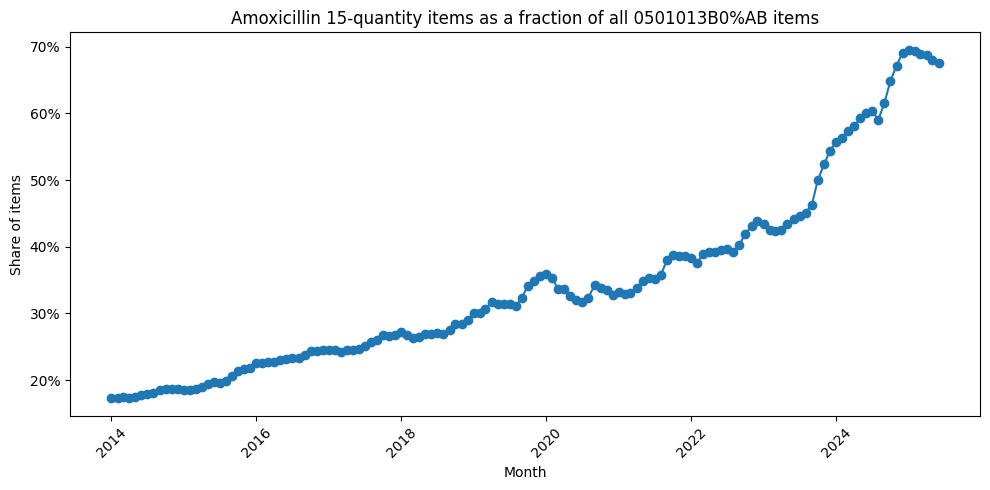

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# --- 5) Plot: fraction vs time (as percentage on y-axis) ---
plt.figure(figsize=(10, 5))
plt.plot(df["month"], df["fraction"], marker="o")
plt.title("Amoxicillin 15-quantity items as a fraction of all 0501013B0%AB items")
plt.xlabel("Month")
plt.ylabel("Share of items")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))  # show as %
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()